**Introduction**  
To analyze an earthquake sequence(occurrence date and magnitude), Epidemic Type Aftershock Sequence(ETAS) model(e.g., Ogata, 1988, 1999) is useful.  
ETAS model is a point process model, including the Omori-Utsu law and branching process in which every earthquake has some ability to generate its own aftershocks.   
Therefore, the seismicity rate at time t is given by summing the effects of all prior earthquakes and background seismicity rate μas,  
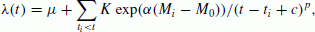
where c and p are parameters in the Omori-Utsu law, K and α control the aftershock productivity by a mainshock and its magnitude sensitivity, respectively. These five parameters, μ, c, p, K,and α, are determined by Maximum Likelihood Estimation(MLE).  

In ETAS model, the log likelihood can be expressed as follows:  
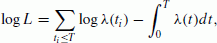

**Reference**  
Ogata, Y., Statistical models for earthquake occurrences and residual analysis for point processes, J. Am. Stat. Assoc, 83, 9–27, 1988. 10.1080/01621459.1988.10478560  
Ogata, Y., Detection of precursory relative quiescence before great earthquakes through a statistical model, J. Geophys. Res, 97, 19845–19871, 1992. 10.1029/92JB00708  
[Okutani, T., and S. Ide (2011), Statistic analysis of swarm activities around the Boso Peninsula, Japan: Slow slip events beneath Tokyo Bay?,Earth Planets Space, 63, 419–426.](https://link.springer.com/article/10.5047/eps.2011.02.010)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import optimize

import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
df = pd.read_csv("../input/database.csv")
df = df.drop([3378,7512,20650]) #Drop error data

In [ ]:
df.describe()

In [ ]:
plt.hist(df["Magnitude"],log=True)

In [ ]:
df_japan = df.query('25 < Latitude < 50 and 125 < Longitude < 150')
df_japan = df_japan.reset_index(drop=True)
df_japan["Date_Time"] = pd.to_datetime(df_japan["Date"]+" "+df_japan["Time"], format = "%m/%d/%Y %H:%M:%S")

In [ ]:
df_japan.describe()

In [ ]:
plt.hist(df_japan["Magnitude"],log=True)
#Magnitude 9.1 is Tohoku Earthquake(2011)

**Inplement ETAS model by using Numpy**  
ETAS parameters are positive. So I use log-transformed parameters to ignore constraint condition.

In [ ]:
###########
#calc λ(t)#
###########
def ramda(param,Tmax,Mc,Ti,Mi,T):
    a,c,p,k,mu=np.exp(param)
    return mu+((T>Ti)*k*np.exp(a*(Mi - Mc))/((T>Ti)*(T - Ti) + c)**p).sum()

####################################
#calc Transformed Time:Λ(t)=∫λ(t)dt#
####################################
def transformed_time(param,Tmax,Mc,Ti,Mi,T):
    a,c,p,k,mu=np.exp(param)    
    if abs(p-1)<0.001:
        N = mu*T + ((T>=Ti)*k*np.exp(a*(Mi - Mc))* \
                    ( (np.log((T>=Ti)*(T - Ti)+ c)**1-np.log(c)**1) \
                     +(np.log((T>=Ti)*(T - Ti)+ c)**2-np.log(c)**2)*(1-p)**1/2 \
                     +(np.log((T>=Ti)*(T - Ti)+ c)**3-np.log(c)**3)*(1-p)**2/6 \
                   )).sum() #using Taylor series at p=1
    else:
        N = mu*T + ((T>=Ti)*k*np.exp(a*(Mi - Mc))*(((T>=Ti)*(T - Ti) + c)**(1-p)-c**(1-p))/(1-p)).sum()
    return N

######################################################
#calc AIC(=-2*loglikelyhood + 2*Number of Parameters)#
######################################################
def calc_aic(param,Tmax,Mc,Ti,Mi):
    a,c,p,k,mu=np.exp(param)
    if abs(p-1)<0.001:
        LogL = np.array([np.log(mu+((t>Ti)*k*np.exp(a*(Mi - Mc))/((t>Ti)*(t - Ti) + c)**p).sum()) for t in Ti]).sum() \
                   - mu*Tmax - ((Tmax>=Ti)*k*np.exp(a*(Mi - Mc))* \
                   ( (np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**1-np.log(c)**1) \
                    +(np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**2-np.log(c)**2)*(1-p)**1/2 \
                    +(np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**3-np.log(c)**3)*(1-p)**2/6 \
                   )).sum()
    else:
        LogL = np.array([np.log(mu+((t>Ti)*k*np.exp(a*(Mi - Mc))/((t>Ti)*(t - Ti) + c)**p).sum()) for t in Ti]).sum() \
                   - mu*Tmax - ((Tmax>=Ti)*k*np.exp(a*(Mi - Mc))*(((Tmax>=Ti)*(Tmax - Ti) + c)**(1-p)-c**(1-p))/(1-p)).sum()
    return -2*LogL+2*5

######################
#calc gradient of AIC#
######################
def calc_grad(param,Tmax,Mc,Ti,Mi):
    a,c,p,k,mu=np.exp(param)
    grad=np.zeros(5)
    
    #∂/∂xΣlogλ(t,x)
    for i, t in enumerate(Ti):
        ramda=mu+((t>Ti)*k*np.exp(a*(Mi - Mc))/((t>Ti)*(t - Ti) + c)**p).sum()
        grad[0]+=((t>Ti)*k*np.exp(a*(Mi - Mc))*(Mi - Mc)                      /((t>Ti)*(t - Ti) + c)**p    ).sum()/ramda
        grad[1]+=((t>Ti)*k*np.exp(a*(Mi - Mc))*(-p)                           /((t>Ti)*(t - Ti) + c)**(p+1)).sum()/ramda
        grad[2]+=((t>Ti)*k*np.exp(a*(Mi - Mc))*np.log(1/((t>Ti)*(t - Ti) + c))/((t>Ti)*(t - Ti) + c)**p    ).sum()/ramda
        grad[3]+=((t>Ti)*1*np.exp(a*(Mi - Mc))                                /((t>Ti)*(t - Ti) + c)**p    ).sum()/ramda
        grad[4]+= 1/ramda
    
    #∂/∂x∫λ(t,t)dt
    if abs(p-1)<0.001:
        grad[0]+= - ((Tmax>=Ti)*k*np.exp(a*(Mi - Mc))*(Mi - Mc)* \
                       (    (np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**1-np.log(c)**1) \
                           +(np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**2-np.log(c)**2)*(1-p)**1/2 \
                           +(np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**3-np.log(c)**3)*(1-p)**2/6 \
                       )).sum() 
        grad[1]+= - ((Tmax>=Ti)*k*np.exp(a*(Mi - Mc))*(((Tmax>=Ti)*(Tmax - Ti) + c)**(0-p)-c**(0-p))).sum()
        grad[2]+= - ((Tmax>=Ti)*k*np.exp(a*(Mi - Mc))* \
                       (   -(np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**2-np.log(c)**2)/2 \
                           -(np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**3-np.log(c)**3)*(1-p)/3 \
                           -(np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**4-np.log(c)**4)*(1-p)**2/8 \
                       )).sum()
        grad[3]+= - ((Tmax>=Ti)*np.exp(a*(Mi - Mc))* \
                       (    (np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**1-np.log(c)**1) \
                           +(np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**2-np.log(c)**2)*(1-p)**1/2 \
                           +(np.log((Tmax>=Ti)*(Tmax - Ti)+ c)**3-np.log(c)**3)*(1-p)**2/6 \
                       )).sum()
        grad[4]+= - Tmax

    else:
        dp=0.001
        pp0=(((Tmax>=Ti)*(Tmax - Ti) + c)**(1-p+dp/2)-c**(1-p+dp/2))/(1-p+dp/2)
        pp1=(((Tmax>=Ti)*(Tmax - Ti) + c)**(1-p-dp/2)-c**(1-p-dp/2))/(1-p-dp/2)
        pp = (pp1-pp0)/dp
        
        grad[0]+= - ((Tmax>=Ti)*k*np.exp(a*(Mi - Mc))*(Mi - Mc)*(((Tmax>=Ti)*(Tmax - Ti) + c)**(1-p)-c**(1-p))/(1-p)).sum()
        grad[1]+= - ((Tmax>=Ti)*k*np.exp(a*(Mi - Mc))*1        *(((Tmax>=Ti)*(Tmax - Ti) + c)**(0-p)-c**(0-p)      )).sum()
        grad[2]+= - ((Tmax>=Ti)*k*np.exp(a*(Mi - Mc))*pp                                                            ).sum()
        grad[3]+= - ((Tmax>=Ti)*1*np.exp(a*(Mi - Mc))*1        *(((Tmax>=Ti)*(Tmax - Ti) + c)**(1-p)-c**(1-p))/(1-p)).sum()
        grad[4]+= - Tmax

    return -2*grad*np.exp(param) #∂f(x)/∂(log(x))=∂f(x)/∂x*x

**Prepare input data and give initial values for ETAS parameters**

In [ ]:
#Prepare input data
Mi=df_japan["Magnitude"].values
Ti=Mi*0
for i,t in enumerate(df_japan["Date_Time"]):
    Ti[i] = (t-df_japan["Date_Time"][0]).total_seconds()/60/60/24

Mc=5.5 #cut off magnitude
Tmax=Ti.max()

#initial values
a,c,p,k,mu=1.0, 0.1, 1.1, 0.1, 0.1
param_initial=np.array([a,c,p,k,mu])

**Fitting ETAS model**

In [ ]:
log_param_initial=np.log(param_initial) #log-param
args=(Tmax,Mc,Ti,Mi)

log_param_fitted=optimize.fmin_bfgs(calc_aic, log_param_initial, fprime=calc_grad, args=(Tmax,Mc,Ti,Mi),gtol=0.0001)
param_fitted = np.exp(log_param_fitted)

print("a,c,p,k,mu=",param_fitted)

**Plot λ(t) and Transformed Time**

In [ ]:
#Plot λ(t)
tmp=[ramda(log_param_fitted,Tmax,Mc,Ti,Mi,t) for t in np.arange(0,Tmax,0.1)]
fig, ax = plt.subplots(figsize=(15,5))
x = np.arange(0,Tmax,0.1)
y = np.log(tmp)
ax.set_xlabel("Time(days)")
ax.set_ylabel("log(λ(t))")
ax.plot(x, y,linewidth = 0.2)
plt.show() 

In [ ]:
#Plot Transformed Time
tmp=[transformed_time(log_param_fitted,Tmax,Mc,Ti,Mi,t) for t in Ti]
fig, ax = plt.subplots(figsize=(10,10)) 
x = np.arange(1, 2092)
y = tmp[1:2092]
ax.set_xlabel("Number of Earthquakes")
ax.set_ylabel("Transformed Time")
ax.plot(x, y)
ax.plot(x, x)
plt.show()